# One Model to rule them All?

In [15]:
import logging
logging.getLogger('polyglot.detect.base').setLevel(logging.ERROR)

In [5]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import shlex
import sentencepiece as spm
import subprocess
import tensorflow_datasets as tfds

from polyglot.text import Text
from tensorflow_datasets.text import wiki40b

In [3]:
BASE_FOLDER_PATH = "/LAB1"

In [6]:
from tensorflow_datasets.text import wiki40b

langs = wiki40b.WIKIPEDIA_LANGUAGES
langs_df = pd.DataFrame(langs, columns=["lang"])
langs_df["morph_cat"] = None
langs_df["ttr"] = None
langs_df["ppl"] = None

In [16]:
morphology_categories = {
    "isolating": ["id", "ms", "tl", "th", "vi", "zh-cn", "zh-tw"],
    "fusional": ["bg", "ca", "cs", "da", "de", "el", "en", "es",\
                "fa", "fr", "hi", "hr", "it", "lt", "lv", "nl", "no", "pl", "pt", "ro", "ru", "sk", "sl", "sr", "sv", "uk"],
    "agglutinative":["et", "fi", "hu", "ja", "ko", "ta", "tr"],
    "introflexive": ["ar", "he"]
}

lang_to_morpho = {lang: category for category, langs in morphology_categories.items() for lang in langs}

langs_df['morph_cat'] = langs_df['lang'].map(lang_to_morpho)

In [23]:
def preprocess_batch(text_batch):
    clean_batch = [re.sub(r'(_START_[^_]+_|_NEWLINE_)\n?', '', text.decode('utf-8')) for text in text_batch]    
    return [sen.string for text in clean_batch for sen in Text(text).sentences]

def read_dataset(lang, split, batch_size=1000, buffer_size=10000, dataset_name="wiki40b", data_dir="gs://tfds-data/datasets"):
    target_size = 40000 if split == "train" else 3000 if split == "test" else None
    if target_size is None: raise ValueError("Split must be 'train' or 'test'")
    
    ds = tfds.load(
        f"{dataset_name}/{lang}",
        data_dir=data_dir, 
        split=split, 
        shuffle_files=True
    ).shuffle(buffer_size=buffer_size).batch(batch_size)

    unique_sentences = set()
    
    def process_batch(batch):
        sentences = preprocess_batch(batch['text'].numpy())
        unique_sentences.update(sentences)

        if len(unique_sentences) >= target_size:
            return False  
        return True  

    for batch in ds:
        continue_processing = process_batch(batch)
        if not continue_processing:
            break
    
    if len(unique_sentences) > target_size:
        unique_sentences = set(list(unique_sentences)[:target_size])

    return unique_sentences

def save_to_file(text, file_path):
    try:
        with open(file_path, 'w', encoding='utf-8') as f:
            f.writelines(f"{sentence}\n" for sentence in text)
    except IOError as e:
        print(f"An error occurred while writing to the file {file_path}: {e}")


def read_file(file_path):
  try:
    with open(file_path, 'r', encoding='utf-8') as f:
      return f.read()

  except FileNotFoundError:
        print(f"File '{file_path}' not found.")


def extract_sentences(text):
    if text is not None:
        return [sentence.strip() for sentence in text.splitlines() if sentence.strip()]    
    return []  


def calculate_perplexity(model, sentences):
    
    total_perplexity = 0.0
    sentence_count = len(sentences)

    for sentence in sentences:
        perplexity = model.perplexity(sentence)
        total_perplexity += perplexity

    if sentence_count > 0:
        average_perplexity = total_perplexity / sentence_count
    else:
        average_perplexity = float('inf')

    return average_perplexity

def calculate_ttr(sentences):
    words = [word.string for word in Text(" ".join(sentences)).words]    
    return len(set(words)) / len(words) if words else 0

def plot_ttr_vs_perplexity(langs_df, ppl_column='ppl', dist=200):
    
    colors = {'isolating': 'blue', 'fusional': 'orange', 'agglutinative': 'green', 'introflexive': 'red'}
    plt.figure(figsize=(10, 8))

    for morph_cat, color in colors.items():
        subset = langs_df[langs_df['morph_cat'] == morph_cat]
        plt.scatter(subset['ttr'], subset[ppl_column], label=morph_cat, color=color)

    for i, row in langs_df.iterrows():
        plt.text(row['ttr'], row[ppl_column] + dist, row['lang'], fontsize=9)

    plt.xlabel('TTR')
    plt.ylabel('Perplexity (PPL)')
    plt.title('TTR vs Perplexity ')
    plt.legend(title='Morphology Category')
    plt.show()

In [14]:
for lang in langs:

    train_sents = read_dataset(lang=lang, split='train')
    test_sents = read_dataset(lang=lang, split='test')
    
    ## write sentences into files
    save_to_file(text=train_sents, file_path=f'{BASE_FOLDER_PATH}/{lang}_train.txt')
    save_to_file(text=test_sents, file_path=f'{BASE_FOLDER_PATH}/{lang}_test.txt')
    
    ## calculate ttr for the train file
    ttr = calculate_ttr(train_sents)
    langs_df.loc[langs_df['lang'] == lang, 'ttr'] = ttr
    

### Kenlm

In [ ]:
!git clone https://github.com/kpu/kenlm.git
%cd kenlm
!python setup.py develop
!mkdir -p build
%cd build
!cmake ..
!make -j 4

In [13]:
def train_kenlm_model(input_file_path, output_arpa_path):
    
    if not os.path.exists(input_file_path):
        print(f'Input directory does not exist')
        return
    
    input_file = shlex.quote(input_file_path)
    output_file = shlex.quote(output_arpa_path)
    
    command = f'./bin/lmplz -o 5 < {input_file} > {output_file}'

    result = subprocess.run(command, shell=True, stderr=subprocess.PIPE, text=True, cwd='./kenlm/build')

    if result.returncode != 0:
        print(f'Error occurred while training the model with input {input_file}:')
        print(result.stderr)
    else:
        print(f'Model trained successfully! Output saved to {output_file}')

In [ ]:
import kenlm

In [ ]:
for lang in langs:
    
    train_file_path = f'{BASE_FOLDER_PATH}/data/{lang}_train.txt'
    test_file_path = f'{BASE_FOLDER_PATH}/data/{lang}_test.txt'
    model_path = f'{BASE_FOLDER_PATH}/arpa/{lang}.arpa'

    train_kenlm_model(input_file_path=train_file_path, output_arpa_path=model_path)

    test_data = read_file(file_path=test_file_path)
    sentences = extract_sentences(text=test_data)
    model = kenlm.Model(model_path)
    ppl = calculate_perplexity(model, sentences)
    langs_df.loc[langs_df['lang'] == lang, 'ppl'] = ppl

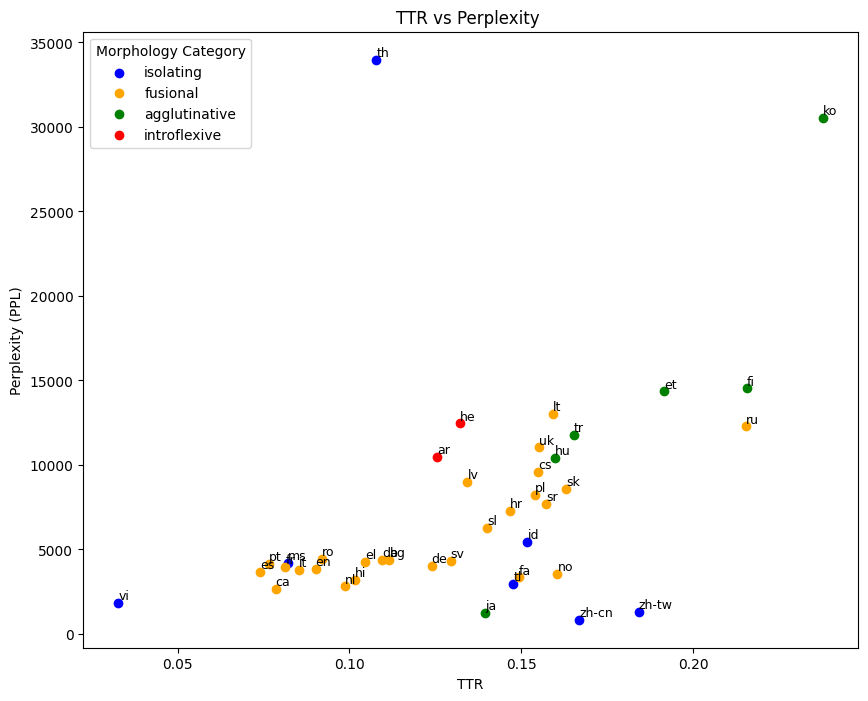

In [11]:
plot_ttr_vs_perplexity(langs_df)

<!-- Get list of languages in the dataset -->

In [10]:
def tokenize_dataset(input_file, output_file, model):
    with open(input_file, 'r', encoding='utf-8') as f_in, open(output_file, 'w', encoding='utf-8') as f_out:
        for line in f_in:
            tokenized_line = model.encode(line.strip(), out_type=str)
            f_out.write(' '.join(tokenized_line) + '\n')

In [ ]:
for lang in langs:
    
    spm_model_prefix = f'{BASE_FOLDER_PATH}/spm/models/{lang}'
    spm_train_file_path = f'{BASE_FOLDER_PATH}/spm/data/{lang}_train.txt'
    spm_test_file_path = f'{BASE_FOLDER_PATH}/spm/data/{lang}_test.txt'
    spm_arpa_file_path = f'{BASE_FOLDER_PATH}/spm/arpa/{lang}.arpa'

    spm.SentencePieceTrainer.train(input=train_file_path, model_prefix=spm_model_prefix, vocab_size=32000)
    sen_model = spm.SentencePieceProcessor(model_file=f'{spm_model_prefix}.model')

    tokenize_dataset(input_file=train_file_path, output_file=spm_train_file_path, model=sen_model)
    tokenize_dataset(input_file=test_file_path, output_file=spm_test_file_path, model=sen_model)
    
    train_kenlm_model(input_file_path=spm_train_file_path, output_arpa_path=spm_arpa_file_path)
    
    test_data = read_file(file_path=spm_test_file_path)
    sentences = extract_sentences(text=test_data)
    model = kenlm.Model(spm_arpa_file_path)
    ppl = calculate_perplexity(model, sentences)
    langs_df.loc[langs_df['lang'] == lang, 'spm_ppl'] = ppl

In [ ]:
plot_ttr_vs_perplexity(langs_df, ppl_column='spm_ppl')

In [17]:
langs_df = pd.read_csv('/Users/zeinab/Downloads/data.csv')

morphology_categories = {
    "isolating": ["id", "ms", "tl", "th", "vi", "zh-cn", "zh-tw"],
    "fusional": ["bg", "ca", "cs", "da", "de", "el", "en", "es", "fa", "fr", "hi", "hr", "it", "lt", "lv", "nl", "no", "pl", "pt", "ro", "ru", "sk", "sl", "sr", "sv", "uk"],
    "agglutinative":["et", "fi", "hu", "ja", "ko", "ta", "tr"],
    "introflexive": ["ar", "he"]
}

lang_to_morpho = {lang: category for category, langs in morphology_categories.items() for lang in langs}

langs_df['morph_cat'] = langs_df['lang'].map(lang_to_morpho)

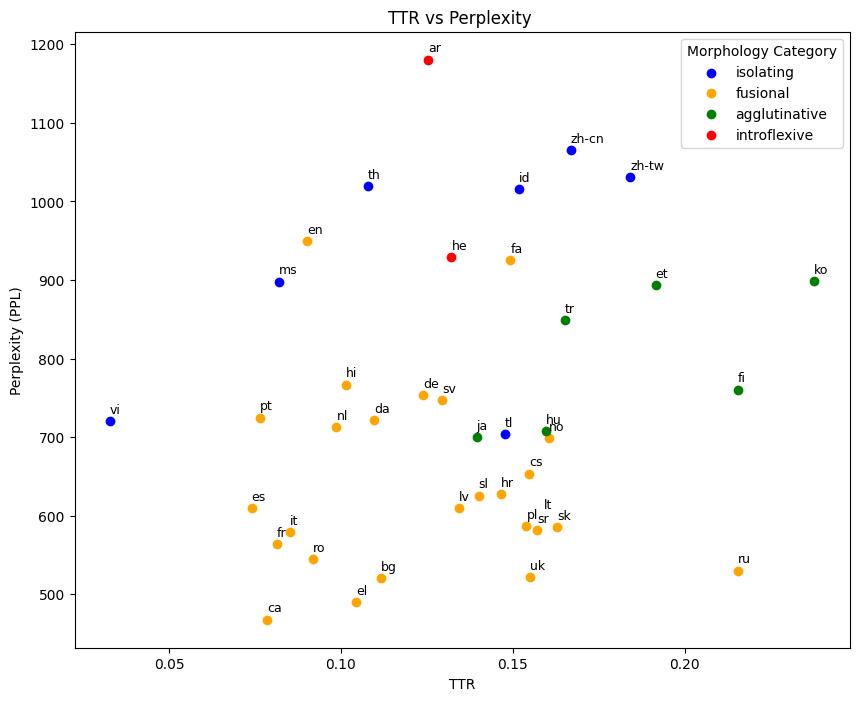

In [22]:
plot_ttr_vs_perplexity(langs_df, ppl_column='new_ppl', dist=10)

In [25]:
langs_df.drop(columns=['label'])

,lang,morph_cat,ttr,ppl,new_ppl
0,en,fusional,0.090150,3828.275264,949.527833
1,ar,introflexive,0.125438,10457.709728,1180.340542
2,zh-cn,isolating,0.166836,838.320947,1065.377585
3,zh-tw,isolating,0.184178,1286.269071,1031.049614
4,nl,fusional,0.098733,2815.744472,712.755578
5,fr,fusional,0.081362,3963.033372,563.801368
6,de,fusional,0.123869,4046.467499,753.193561
7,it,fusional,0.085317,3781.675218,579.610911
8,ja,agglutinative,0.139528,1223.598364,699.631626
9,ko,agglutinative,0.237714,30549.469260,898.206141


<!-- ### Install kenlm -->